In [1]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier

import os, sys
sys.path.append(os.path.abspath(".."))
from utils.common import save_model

seed = 42
np.random.seed(seed)

### 1. Các thông tin về dữ liệu

In [2]:
train_df = pd.read_csv("train_clean.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               2977 non-null   object 
 1   nose_x              2977 non-null   float64
 2   nose_y              2977 non-null   float64
 3   nose_z              2977 non-null   float64
 4   left_shoulder_x     2977 non-null   float64
 5   left_shoulder_y     2977 non-null   float64
 6   left_shoulder_z     2977 non-null   float64
 7   right_shoulder_x    2977 non-null   float64
 8   right_shoulder_y    2977 non-null   float64
 9   right_shoulder_z    2977 non-null   float64
 10  left_elbow_x        2977 non-null   float64
 11  left_elbow_y        2977 non-null   float64
 12  left_elbow_z        2977 non-null   float64
 13  right_elbow_x       2977 non-null   float64
 14  right_elbow_y       2977 non-null   float64
 15  right_elbow_z       2977 non-null   float64
 16  left_w

In [4]:
train_df.columns

Index(['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y',
       'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x',
       'right_wrist_y', 'right_wrist_z', 'left_hip_x', 'left_hip_y',
       'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z',
       'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x',
       'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y',
       'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z',
       'left_heel_x', 'left_heel_y', 'left_heel_z', 'right_heel_x',
       'right_heel_y', 'right_heel_z', 'left_foot_index_x',
       'left_foot_index_y', 'left_foot_index_z', 'right_foot_index_x',
       'right_foot_index_y', 'right_foot_index_z'],
      dtype='object')

In [5]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,C,0.213642,0.007156,-0.055131,0.151826,-0.035799,0.125803,0.154366,-0.007986,-0.187625,...,0.245712,-0.235022,0.039568,0.065375,-0.229869,0.121924,0.206447,-0.238722,0.123362,0.003764
1,C,0.222368,-0.071354,-0.070117,0.151103,-0.079363,0.100696,0.149426,-0.040178,-0.170662,...,0.266025,-0.232282,0.007561,0.100571,-0.224483,0.093258,0.233096,-0.237525,0.093753,0.048710
2,C,0.216170,-0.067472,-0.063832,0.144396,-0.059443,0.109028,0.144433,-0.036645,-0.163427,...,0.214913,-0.233871,0.011221,0.040485,-0.237365,0.087917,0.176753,-0.248834,0.088290,-0.018377
3,C,0.218257,-0.071693,-0.079761,0.145390,-0.058949,0.099756,0.144829,-0.039815,-0.179505,...,0.245903,-0.233383,0.013893,0.071552,-0.232242,0.087876,0.207229,-0.245439,0.088420,0.011916
4,C,0.219348,-0.067729,-0.081575,0.146637,-0.056749,0.097673,0.146361,-0.037216,-0.178930,...,0.240968,-0.229545,0.014394,0.078501,-0.233238,0.088282,0.203226,-0.244404,0.087259,0.021840


### 2. Training model

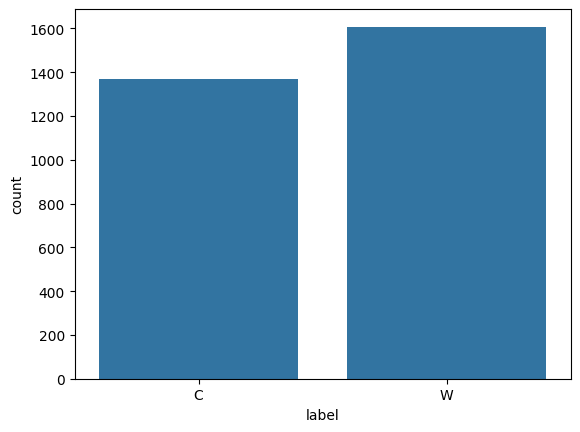

In [6]:
sns.countplot(x="label", data=train_df);

In [7]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [9]:
# Extract features
X_train = train_df.drop(columns="label")
y_train = train_df["label"]

In [10]:
X_train.head()

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_elbow_x,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0.213642,0.007156,-0.055131,0.151826,-0.035799,0.125803,0.154366,-0.007986,-0.187625,0.142400,...,0.245712,-0.235022,0.039568,0.065375,-0.229869,0.121924,0.206447,-0.238722,0.123362,0.003764
1,0.222368,-0.071354,-0.070117,0.151103,-0.079363,0.100696,0.149426,-0.040178,-0.170662,0.139137,...,0.266025,-0.232282,0.007561,0.100571,-0.224483,0.093258,0.233096,-0.237525,0.093753,0.048710
2,0.216170,-0.067472,-0.063832,0.144396,-0.059443,0.109028,0.144433,-0.036645,-0.163427,0.130698,...,0.214913,-0.233871,0.011221,0.040485,-0.237365,0.087917,0.176753,-0.248834,0.088290,-0.018377
3,0.218257,-0.071693,-0.079761,0.145390,-0.058949,0.099756,0.144829,-0.039815,-0.179505,0.131297,...,0.245903,-0.233383,0.013893,0.071552,-0.232242,0.087876,0.207229,-0.245439,0.088420,0.011916
4,0.219348,-0.067729,-0.081575,0.146637,-0.056749,0.097673,0.146361,-0.037216,-0.178930,0.135215,...,0.240968,-0.229545,0.014394,0.078501,-0.233238,0.088282,0.203226,-0.244404,0.087259,0.021840


In [11]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
2972    1
2973    1
2974    1
2975    1
2976    1
Name: label, Length: 2977, dtype: int32

In [12]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [13]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

array([[ 1.13718185, -0.13498598,  0.38558575, ..., -1.16022966,
         0.10409338, -0.68759381],
       [ 1.18363078, -1.03561398,  0.26324523, ..., -1.15417484,
        -0.44077512, -0.4792968 ],
       [ 1.15063574, -0.99108022,  0.314555  , ..., -1.21138788,
        -0.54130572, -0.79020276],
       ...,
       [-0.79750392, -0.08710728, -1.32646672, ...,  0.60543028,
        -1.09582869,  1.27381428],
       [-0.77296897, -0.09459442, -1.69590293, ...,  0.48536763,
        -0.90190689,  1.7494813 ],
       [-0.77412857, -0.11633036, -1.71482473, ...,  0.56054098,
        -0.72962811,  1.73213717]])

In [14]:
import warnings
warnings.filterwarnings("ignore")

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [15]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X_train, y_train, cv=k_fold, scoring="accuracy", n_jobs=-1, verbose=1
    ).mean()

    f1_score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [16]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("SVC", SVC(probability=True, random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("RF", RandomForestClassifier(random_state=seed)),
    ("XGB", XGBClassifier(random_state=seed)),
]

models = {}
results_before_tunning = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model
    evaluate_model(name, model, results_before_tunning)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [17]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,RF,0.921409,0.920874
1,XGB,0.916370,0.915759
2,KNN,0.892859,0.892429
3,SVC,0.879747,0.879526
4,DTC,0.858925,0.857940
5,LR,0.752444,0.751295


### Điều chỉnh siêu tham số cho các model

In [18]:
from sklearn.model_selection import RandomizedSearchCV

results_after_tuning = []

##### 1.1. Điều chỉnh siêu tham số cho Random Forest

In [ ]:
random_forest = models["RF"]

  # Định nghĩa phạm vi của các siêu tham số cần tối ưu
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Tạo RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = random_forest, param_distributions = param_grid,
                                n_iter = 100, cv = k_fold, verbose=3, random_state=seed, n_jobs = -1)

# Tiến hành tìm kiếm siêu tham số
random_search.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất được tìm thấy
print("Best Parameters:", random_search.best_params_)

##### 1.2. Kiểm tra sự cải thiện của độ chính xác sau khi điều chỉnh siêu tham số cho Random Forest

In [24]:
import json
with open('./hyper_parameter/random_forest.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

# Khởi tạo một mô hình Random Forest mới với các tham số tối ưu
best_random_forest_model = RandomForestClassifier(**best_params, random_state=seed, verbose=1)
best_random_forest_model.fit(X_train, y_train)

# Huấn luyện mô hình mới với dữ liệu huấn luyện của bạn
result = []
evaluate_model("RF", best_random_forest_model, result)
results_after_tuning.append(result[0])
print_results(result)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.5s remaining:   27.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:   10.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks  

,Model,Accuracy score,F1 score
0,RF,0.924768,0.924246


##### 2.1. Điều chỉnh siêu tham số cho SVC

In [77]:
from sklearn.model_selection import GridSearchCV

svc_model = models["SVC"]

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
}

# Tạo GridSearchCV instance
svc_best_model = GridSearchCV(svc_model, param_grid, cv=5, verbose=3, n_jobs=-1)

# Tiến hành tinh chỉnh siêu tham số trên mô hình đã huấn luyện
svc_best_model.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất được tìm thấy
print("Best Parameters:", svc_best_model.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


##### Kiểm tra sự cải thiện của độ chính xác sau khi điều chỉnh siêu tham số cho SVC

In [26]:
best_params = {"C": 100, "gamma": 0.001, "kernel": "rbf"}
svc_best_model = SVC(**best_params, random_state=seed)
svc_best_model.fit(X_train, y_train)

SVC(C=100, gamma=0.001, random_state=42)

In [27]:
results = []
evaluate_model("SVC", svc_best_model, results)
results_after_tuning.append(results[0])
print_results(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


,Model,Accuracy score,F1 score
0,SVC,0.886467,0.886203


In [ ]:
save_model(svc_best_model, "./best_models/SVC_model.pkl")

##### 3.1. Điều chỉnh siêu tham số cho các thuật toán còn lại

In [43]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": [
            "l1",
            "l2",
            "elasticnet",
            "none",
        ],  # Different norms for regularization
        "class_weight": ["balanced"],  # Added class_weight
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20],  # Added min_samples_leaf
        "class_weight": ["balanced"],
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": [
            "euclidean",
            "manhattan",
            "chebyshev",
            "minkowski",
        ], 
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid[name],
            n_iter=100,  # You can adjust the number of iterations
            cv=k_fold,
            scoring="accuracy",
            random_state=seed,
            n_jobs=-1,
            verbose=1,
        )
        randomized_search.fit(X_train, y_train)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")

Model processing:  LR
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  KNN
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  DTC
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
with open("hyper_parameter/other_algorithms.json", "w") as f:
    json.dump(best_params_random_other, f)

In [21]:
with open("hyper_parameter/other_algorithms.json", "r") as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ("KNN", KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

for name, model in algorithms:
    result = [] 
    evaluate_model(name, model, result)
    results_after_tuning.append(result[0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


#### Kết quả trước và sau khi điều chỉnh siêu tham số

In [23]:
print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,RF,0.921409,0.920874
1,XGB,0.916370,0.915759
2,KNN,0.892859,0.892429
3,SVC,0.879747,0.879526
4,DTC,0.858925,0.857940
5,LR,0.752444,0.751295


In [122]:
print_results(results_after_tuning)

,Model,Accuracy score,F1 score
0,RF,0.924768,0.924246
1,KNN,0.912335,0.911944
2,SVC,0.886467,0.886203
3,DTC,0.867656,0.866825
4,LR,0.785690,0.785165


### Confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [ ]:
with open('./hyper_parameter_v2/random_forest.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

rf_best_model = RandomForestClassifier(**best_params, random_state=seed)
rf_best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, max_features='log2', n_estimators=1400,
                       random_state=42)

In [ ]:
y_pred = rf_best_model.predict(X_train)
cm_full_train = confusion_matrix(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
cm_full_train, accuracy

(array([[1369,    0],
        [   8, 1600]], dtype=int64),
 0.9973127309371851)

In [ ]:
accuracy = cross_val_score(rf_best_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(rf_best_model, X_train, y_train, cv=k_fold)
cm_cross_val = confusion_matrix(y_train, y_pred)
accuracy, cm_cross_val

(0.9247684845750381,
 array([[1260,  109],
        [ 115, 1493]], dtype=int64))

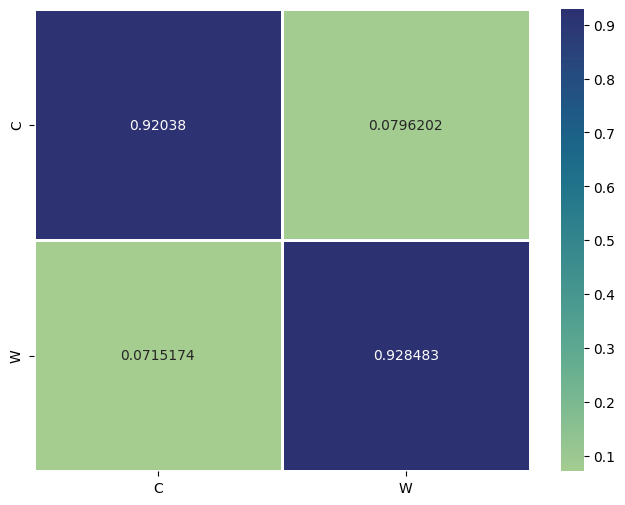

In [ ]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["C", "W"], columns=["C", "W"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest");

#### Lưu lại model

In [ ]:
save_model(scaler, "./best_models/input_scaler.pkl")
save_model(rf_best_model, "./best_models/RF_model.pkl")